In [1]:
%load_ext autoreload
%autoreload 2

# Latent Dirichlet Allocation (LDA)

## Intro

The notebook relies heavily on [Kevin Murphy's _Machine Learning A Probabilistic Perspective_ (p. 950)](https://www.cs.ubc.ca/~murphyk/MLbook/). The original work is described in [Latent Dirichlet Allocation](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) by Blei et al. [Griffiths and Steyvers in _Finding scientific topics_](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC387300/pdf/1015228.pdf) extended LDA toolkit by proposing a new parameter estimation technique through the collapsed Gibbs sampling. Some parts are directly taken from these works. Also, you can find [_Latent Dirichlet Allocation: Towards a Deeper
Understanding_](http://obphio.us/pdfs/lda_tutorial.pdf) helpful during the implementation.

LDA belongs to the family of probabilistic graphical models that found many applications in working discrete data such gene descriptions and text corpora. This three-level hierarchical Bayesian model models each item in the collection with a finite mixture over an underlying set of topics. Each topic is modeled with a mixture of topic probabilities. These topic are not necessarily thematical topics in texts but in corpora they have a direct intrepretation. It is depicted as below

![LDA](assets/lda.png)

## How does it work

We assume that we work with text documents, hence it is easier to introduce a few concepts. The basic idea is that documents are represented as random mixtures over latent topics, where each topic is characterized by a distribution over words. LDA assumes the following generative process for each document $\mathbf{w}$ in a corpus $\mathcal{D}$:

1. Choose $N \sim \text{Poisson}(\xi)$ (length of the document)
2. Choose $\theta \sim \text{Dir}(\alpha)$ (choose probabilities of topics from the Dirichlet simplex, which conjugate to the Multinomial)
3. For each of the $N$ words $w_n$:
   1. Choose a topic $z_n \sim \text{Multinomial}(\theta)$
   2. Choose a word $w_n$ from $p(w_n | z_n, \beta)$, a multinomial probability conditioned on the topic $z_n$ (each word has an assigned topic to it, $\beta$ is a parameter of the prior over topics for words)
   
A few notes. $z_n$ is a $k$-dimensional simplex of topics. The $k$ is set upfront (however, we note that there exist methods for estimating it, such as Dirichlet Process) and stands for the number of topics. Word probabilities are parametrized by a $k \times V$ matrix $\beta$ ($V$ is a size of the vocabulary that has to be set upfront as well), and $\beta_{ij} = p(w^j = 1 | z^i = 1)$ (probability of the $j$-th word occurence in the $i$-th topic context).

Given the parameters $\alpha$  and $\beta$ (which have to be estimated during preprocessing of the corpus), the joint distribution of a topic mixture $\theta$, a set of $N$ topics $\mathbf{z}$, and a set of $N$ words $\mathbf{w}$ is given by:

$$
p(\boldsymbol{\theta}, \mathbf{z}, \mathbf{w} | \boldsymbol{\alpha}, \boldsymbol{\beta}) = p(\boldsymbol{\theta} | \boldsymbol{\alpha}) \prod^N_{n=1} p(z_n | \boldsymbol{\theta}) p(w_n | z_n, \boldsymbol{\beta})
$$

By marginilizing over parameters, we obtain the distribution of a single documents (how likely is a set of words for a particular document):

$$
p(\mathbf{w} | \boldsymbol{\alpha}, \boldsymbol{\beta}) = \int p(\boldsymbol{\theta}|\boldsymbol{\alpha})\left(\prod^N_{n=1} \sum_{z_n} p(z_n | \boldsymbol{\theta}) p(w_n | z_n, \boldsymbol{\beta}) \right)d\boldsymbol{\theta}
$$

and by taking the product of the marginal probabilities of single documents  - probability of a corpus:

$$
p(\mathcal{D}|\boldsymbol{\alpha},\boldsymbol{\beta}) = \prod^M_{d=1}\int p(\theta_d|\boldsymbol{\alpha}) \left( \prod^{N_d}_{n=1}\sum_{z_{dn}}p(z_{dn} | \theta_d)p(w_{dn} | z_{dn}, \boldsymbol{\beta}) \right)d\theta_d
$$


## Geometrical interpretation

The LDA can considered as a dimensionality reduction algorithm (similar to the PCA). However, while the PCA works in Euclidean spaces, the LDA works in simplex spaces that, and thus it can handle ambiguities in words (so called "polysemy"). 

Words are distributed over $V - 1$ dimensional simplex (word simplex). The LDA considers $k$ points on the on the word simplex and forms a subsimplex of a lower dimensionality (topic simplex). Therefore, each word is cast on the subsimplex.

LDA posits that each word of both the observed and unseen documents is generated by a randomly chosen topic which is drawn from a distribution with a randomly chosen parameter. This parameter is sampled once per document from a smooth distribution on the topic simplex.

## Variational inference

Due to complex variable coupling, visible in the plate model, it is intractable to derive exact inference. However, it is possible to perform some sort of decoupling by removing edges from the original model. The variational distribution is derived then as

![Variational model](assets/variational.png)

The distribution is described as

$$
q(\boldsymbol{\theta}, \mathbf{z} | \boldsymbol{\gamma}, \boldsymbol{\phi}) = q(\boldsymbol{\theta}|\boldsymbol{\gamma}) \prod^N_{n=1} q(z_n | \phi_n)
$$

where the Dirichlet parameter $\boldsymbol{\gamma}$ and the multinomial parameters $(\phi_1,...,\phi_N)$ are the free variational parameters.  In the language of text, the optimizing parameters $(\boldsymbol{\gamma}(\mathbf{w}),\boldsymbol{\phi}(\mathbf{w}))$ are document-specific. In particular, we view the Dirichlet parameters $\boldsymbol{\gamma}(\mathbf{w})$ as providing a representation of a document in the topic simplex.


By setting KL divergence in the VI framework, we obtain update equations:

\begin{align}
\phi_{ni} &\propto \beta_{iw_n} \exp\{\mathbb{E}_q[\log(\theta_i)|\boldsymbol{\gamma}]\} \\
\gamma_i &= \alpha_i + \sum^N_{n=1} \phi_{ni}
\end{align}

The expectation is equal to the: 

$$
\mathbb{E}_q[\log(\theta_i)|\boldsymbol{\gamma}] = \Psi(\gamma_i) - \Psi\left(\sum^k_{j=1} \gamma_j\right)
$$

where $\Psi$ is [digamma function](https://en.wikipedia.org/wiki/Digamma_function) (implemented in `pytorch`)

The algorithm for the inference is performed as alternated updates of these parameters through $t \in \{1, ..., T\}$ steps.

![Inference](assets/inference.png)

We recall, that $k$ denotes number of topics (hyperparameter) and $N$ - number of words in the document.

## Parameter estimation using Variational Bayes

In particular, given a corpus of documents $\mathcal{D} = \{\mathbf{w}_1, ..., \mathbf{w}_M\}$ (M documents), we wish to find parameters $\boldsymbol{\alpha}$ and $\boldsymbol{\beta}$ that maximize the (marginal) log likelihood of the data:

$$
\mathcal{l}(\boldsymbol{\alpha}, \boldsymbol{\beta}) = \sum^M_{d=1} \log p(\mathbf{w}_d | \boldsymbol{\alpha}, \boldsymbol{\beta})
$$

The equation can be optimized through variational EM that maximizes a lower bound with respect to the variational parameters $\boldsymbol{\gamma}$ and $\boldsymbol{\phi}$, and, then for fixed values of the variational parameters, maximizes the lower bound with respect to the model parameters $\boldsymbol{\alpha}$ and $\boldsymbol{\beta}$. 

The algorithm is as follows:
1. (E-step) For each document, find the optimizing values of the variational parameters $\{\boldsymbol{\gamma}_d, \boldsymbol{\phi}_d : d \in \mathcal{D}\}$. This is done as described in the previous section.

2. (M-step) Maximize the resulting lower bound on the log likelihood with respect to the model parameters $\boldsymbol{\alpha}$ and $\boldsymbol{\beta}$. This corresponds to finding maximum likelihood estimates with expected sufficient statistics for each document under the approximate posterior which is computed in the E-step.

These two steps are repeated until the lower bound on the log likelihood converges.

The M-step can be written analitacilly as:

$$
\beta_{ij} \propto \sum^M_{d=1}\sum^{N_d}_{n=1} \phi_{dni}w^j_{dn}
$$

Note that, $\boldsymbol{\beta}$ has to be normalized afterwards.

$$
\mathcal{L}_\alpha = \sum^M_{d=1} 
\left( 
    \log\Gamma
    \left(
        \sum^k_{j=1}\alpha_j
    \right) 
    - \sum^k_{i=1} \log\Gamma
    \left(
        \alpha_i
    \right)
    + \sum^k_{i=1}
    \left(
        \left(
            \alpha_i -1
        \right)
        \left(
            \Psi
            \left(
                \gamma_{di}
            \right) 
            - \Psi
            \left(
                \sum^k_{j=1}\gamma_{dj}
            \right)
        \right) 
    \right)
\right)
$$

We have already implemented optimizing $\alpha$ so you can focus on other implementation details.

## Additional hyperparameters

Full LDA models consider one additional parameters can be estimated: $\eta$. 

$\eta$ is a parameter telling about smoothing. The smoothing is necessary due to long-tail distribution of words, where many words in the vocabulary can be absent in many documents. The common approach is to use Laplace smoothing (add some constant to each count entry), however it is not applicable for the LDA directly. Blei et al. defined a new node in the PGM of the LDA that holds additional smoothing values, that contribute to the join probability. Again, derivation of its values require application of the Newton-Raphson method (in a similar way). The data, you will use, was preprocessed in such a way, that it will not be necessary to estimate and use $\eta$ params.

## Parameter estimation using Gibbs Sampling

Resources:
- _[Latent Dirichlet Allocation](http://acsweb.ucsd.edu/~yuw176/report/lda.pdf)_ (description of the perplexity calculation)
- _[Finding scientific topics](https://www.pnas.org/content/pnas/101/suppl_1/5228.full.pdf)_ (first proposition of the collapsed Gibbs sampling for the LDA
- _[Machine Learning: A Probabilistic Perspective](https://bit.ly/3cSB6g1)_ (p. 955)
- _[A Theoretical and Practical Implementation Tutorial on Topic Modeling and Gibbs Sampling](http://www.ccs.neu.edu/home/vip/teach/DMcourse/5_topicmodel_summ/notes_slides/sampling/darling-lda.pdf)_

The Gibbs Sampling approach corresponds to the "fuller" plate representation of the LDA:

![fuller lda](https://www.researchgate.net/publication/303203779/figure/fig1/AS:485818495180800@1492839563094/Graphical-representation-of-the-LDA-model-The-shaded-circle-represents-the-observed.png)

Gibbs Sampling is one member of a family of algorithms from the Markov Chain Monte Carlo (MCMC) framework. The MCMC algorithms aim to construct a Markov chain that has the target posterior distribution as its stationary distribution. In other words, after a number of iterations of stepping through the chain, sampling from the distribution should converge to be close to sampling.

For LDA, we are interested in the latent document-topic portions $\theta_d$ for the $d\in \mathcal{D}$ document, the topic-word distributions $\phi$ of size $K \times V$ (distribution of words per each $k$-th topic), and the topic index assignments $\mathbf{z}_d$ for each word in $\mathbf{w}_{d}$. While conditional distributions – and therefore an LDA Gibbs Sampling algorithm – can be derived for each of these latent variables, we note that both $\theta_d$ and $\phi$ can be calculated using just the topic index assignments $\mathbf{z}_d$ (i.e. $\mathbf{z}$ is a sufficient statistic for both these distributions). Therefore, a simpler algorithm can be used if we integrate out the multinomial parameters and simply sample $\mathbf{z}_d$. This is called a collapsed Gibbs sampler.

The collapsed Gibbs sampler for LDA needs to compute the probability of a topic z being assigned to a word $w_{d,i}$, given all other topic assignments to all other words. Somewhat more formally, we are interested in computing the following posterior up to a constant:

$$
p(z_{d,i} | \mathbf{z}_{d,-i}, \alpha, \beta, \mathbf{w}_d)
$$

where $\mathbf{z}_{d,-i}$ means all topic allocations _except_ for $z_{d,i}$.

Implementing an LDA collapsed Gibbs sampler is surprisingly straightforward. It involves setting up the requisite count variables, randomly initializing them, and then running a loop over the desired number of iterations where on each loop a topic is sampled for each word instance in the corpus. Following the Gibbs iterations, the counts can be used to compute the latent distributions $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$. The only required count variables include $n_{d,k}$, the number of words assigned to topic $k$ in document $d$; and $n_{k,w}$, the number of times word $w$ is assigned to topic $k$. Finally, in addition to the obvious variables such as a representation of the corpus ($\mathbf{w}$), we need an array $\mathbf{z}$ which will contain the current topic assignment for each of the $N$ words in the corpus.

The algorithm is defined as (notation is adapted from Murphy's book, refer there for more info):


1. For each word $w_{d,i}$ sample a topic from

$$
z_{d,i} \sim \text{Categorical}(p(z_{d,i})), \qquad  p(z_{d,i} = k | \cdot) \propto \exp\left\{ \log(\theta_{d,k}) + \log(\phi_{k, v_{w_{d,i}}}) \right\}
$$

where $v_{w_{d,i}}$ denotes dictionary index of the word, $v_{w_{d,i}} \in V$

2. Estimate parameters of the topic $k$ distribution for each document $d$, $\theta_{d,k}$

        
$$
\theta_{d,k}  = \frac{\alpha + n_{d,k}}{K\alpha + n_d} \qquad \text{or} \qquad p(\theta_{d,k} | \cdot) = \text{Dirichlet}\left(\left\{ \alpha + \sum_j\mathbb{1}[z_{d,j} = k] \right\}\right)
$$

where $n_{d,k}$ is a number of words in document $d$ that were assigned to the topic $k$, $n_d$ is a number of words in the $d$ document, and $\mathbb{1}[z_{d,j} = k]$ returns one if the topic index for the word $w_{d,j}$ is equal to $k$. Both equations are equal, while the first one being the MAP estimate. It's your choice which one to implement, however both should converge to a similar solution.

3. Estimate parameters of the word distribution for each topic $\phi_{k,v}$
        
$$
\phi_{k, v} = \frac{\beta + n_{k, v}}{V\beta + n_k} \qquad \text{or} \qquad p(\phi_{k,v} | \cdot) = \text{Dirichlet}\left(\left\{\beta + \sum_{d\in\mathcal{D}}\sum_{i} \mathbb{1}[w_{d,i} = v, z_{d,i} = k] \right\}\right)
$$

where $n_{k,v}$ is a number of assignments of word $v$ to the topic $k$ in all documents, $n_k$ is a number of all words assigned to the topic $k$, and $\mathbb{1}[w_{d,i} = v, z_{d,i} = k]$ returns one if the word $w_{d,i}$ is the same word as $v$ and it is assigned to the topic $k$. Both equations are equal, while the first one being the MAP estimate. It's your choice which one to implement, however both should converge to a similar solution.

4. Repeat until convergence or for predefined number of steps.

The algorithm differs from the VG in such a way, that it does not learn / estimate $\beta$ and $\alpha$ parameters - these only serve as a prior knowledge about our model and are set as scalars in that frameworks. 

## Perplexity

The model can evaluated using perplexity measure, a standard metric in natural language processing

$$
perplexity(\mathcal{D}) = \exp\left\{-\frac{\sum^M_{d=1} \log p(\mathbf{w}_d)}{\sum^M_{d=1} N_d} \right\}
$$

in the general form, where

$$ 
\log p(\mathbf{w}_d) = \sum_{v \in V} n_{d,v} \log\left( \sum_{k\in K}\phi_{k,v}\cdot \theta_{d,k}  \right)
$$

and $n_{d,v}$ denotes number of occurences of word $v$ in the $d$ document.


Intuitively, perplexity measures the weighted average **branching factor** of the model's predictive distribution. Suppose the model predicts that each symbol (letter, word, whatever) is equally likely, so $p(y_i|\mathbf{y}_{1:i-1}) = 1 / K$. Then the perplexity is $((1 / K)^N)^{-1/N} = N$. So for $V = 1000$, maximum perplexity is 1000, and mimnimal is 0. If some symbols are omre likely than others, and the model correctly reflects this, its perplexity will be lower than K. Of course, $H(p, p) = H(p) \leq H(p,q)$ (for two stochastic processes $p$, $q$), so we can never reduce the perplexity below the entropy of the true underlying stochastic proceess.

## Tasks

- Implement generating topic assignments for words
- Implement estimation of topic distribution parameters for each document
- Implement estimation of words distribution parameters for each topic
- Implement calculating perplexity 
- Implement getting topic distribution for a word and most probable topic for a document (we asssume that these methods are evaluated on the train dataset only)

**Note:** You can freely change parameters defined in `src/common.py` for debugging purposes.

## Dataset

The data set I used is the 20Newsgroup data set. The data set is already preprocessed and both train and test splits consists of list of documents where each document $d$ has $N_d$ words. Words have been already lemmatized, stemmed and stop words have been removed. There are 20 targets in the data set — `alt.atheism`, `comp.graphics`, `comp.os.ms-windows.misc`, `comp.sys.ibm.pc.hardware`, `comp.sys.mac.hardware`, `comp.windows.x`, `misc.forsale`, `rec.autos`, `rec.motorcycles`, `rec.sport.baseball`, `rec.sport.hockey`, `sci.crypt`, `sci.electronics`, `sci.med`, `sci.space`, `soc.religion.christian`, `talk.politics.guns`, `talk.politics.mideast`, `talk.politics.misc`, `talk.religion.misc`.

Looking visually we can say that this data set has a few broad topics like:
- Science
- Politics
- Sports
- Religion
- Technology etc.

In [2]:
from collections import Counter
from typing import List

import gensim
import numpy as np
import torch
import torch.distributions as dist

from src.base import BaseLDA
from src.data_utils import get_newsgroup_dataset
from src.visualization import sentences_chart, visualize_history, display_topics

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/telepchuk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
(train_texts, test_texts), dictionary = get_newsgroup_dataset()

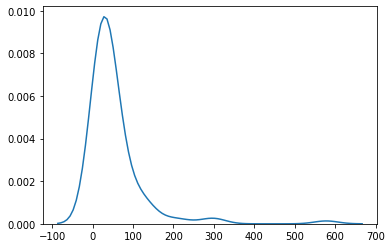

In [4]:
import seaborn as sns

sns.kdeplot([len(doc) for doc in train_texts])

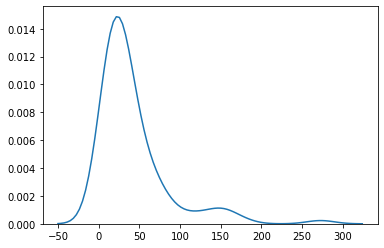

In [5]:
sns.kdeplot([len(doc) for doc in test_texts])

In [6]:
print("Most common words in the train dataset:")
Counter([word for doc in train_texts for word in doc]).most_common(20)

Most common words in the train dataset:


[('scsi', 37),
 ('orbit', 33),
 ('space', 29),
 ('insur', 28),
 ('jew', 27),
 ('imag', 26),
 ('window', 26),
 ('control', 24),
 ('launch', 23),
 ('list', 23),
 ('armi', 23),
 ('power', 22),
 ('engin', 21),
 ('drive', 21),
 ('speed', 20),
 ('understand', 20),
 ('option', 20),
 ('hand', 19),
 ('current', 19),
 ('close', 19)]

In [7]:
print("Most common words in the test dataset:")
Counter([word for doc in test_texts for word in doc]).most_common(20)

Most common words in the test dataset:


[('muslim', 31),
 ('game', 27),
 ('govern', 25),
 ('april', 25),
 ('nation', 24),
 ('drive', 23),
 ('perform', 21),
 ('player', 21),
 ('group', 20),
 ('command', 20),
 ('happen', 19),
 ('test', 19),
 ('card', 19),
 ('degre', 19),
 ('play', 18),
 ('send', 17),
 ('design', 17),
 ('call', 15),
 ('feel', 15),
 ('andrew', 15)]

In [8]:
print("Num documents: {}".format(dictionary.num_docs))
print("Num unique words: {}".format(len(dictionary.values())))

Num documents: 100
Num unique words: 1000


In [9]:

class LDA(BaseLDA):
    def __init__(
        self,
        num_optim_steps: int,
        num_topics: int,
        dictionary: gensim.corpora.Dictionary,
    ):
        super().__init__(
            num_optim_steps=num_optim_steps,  # number of optimization step
            num_topics=num_topics,  # number of topics
            dictionary=dictionary,  # contains the information about mappings word to indices
        )
    
    def assign_topics_to_words(
        self,
        data: List[torch.Tensor],
        document_topic_dist_theta: torch.Tensor,
        topic_word_dist_phi: torch.Tensor,
    ) -> List[torch.Tensor]:
        """Generate topic assigments for each word in each document.
        
        :param dataset: Each entry is a list of indices (a single document)
            with the variable length and the whole parameter represents list of 
            documents. In a single document, words are indices from the dictionary
            (tensor N_d of longs).
        :param document_topic_dist_theta: Matrix D x K where each row entry
            has parameters of the topic distributions (a'ka probability that
            the document has a particular topic)
        :param topic_word_dist_phi: Matrix K x V where each row entry
            has parameters of the topic distributions (a'ka probability that
            the topic has a particular word).
        :return: List of topic assignments for each word in each document
            sampled from the categorical distribution.
        """
        # TODO: Sample topic assignments for each word in each document

        assignmets = []

        for d, word_indices in enumerate(data):
            z_d = []
            for v in word_indices:
                p = ((document_topic_dist_theta[d,:]).log() +
                    (topic_word_dist_phi[:,v]).log()).exp()
                z_di = dist.Categorical(p).sample()
                z_d.append(z_di)
            assignmets.append(z_d)
        return assignmets
        
    def estimate_document_topic_distribution_theta(
        self, data: List[torch.Tensor], topic_assignments_z: List[torch.Tensor]
    ) -> torch.Tensor:
        """Estimate matrix theta.
        
        Each entry in the matrix describes probability of the topic
        being assigned to the $d$-th document.
        :param data: Each entry is a list of indices (a single document)
            with the variable length and the whole parameter represents list of 
            documents. In a single document, words are indices from the dictionary
            (tensor N_d of longs).
        :param topic_assignments_z: Each entry corresponds to the `data` and 
            consists of topic assignments for each word in documents.
        :return: Estimated matrix theta.
        """
        # TODO: Perform calculation to estimate theta matrix parameters

        z = topic_assignments_z
        alpha = self.alpha
        
        topic_indices = torch.arange(self.num_topics)
        theta = torch.zeros((len(data), self.num_topics))

        for d, word_indices in enumerate(data):
            z[d] = torch.tensor(z[d])
            for k in topic_indices:
                theta[d][k] = alpha + (z[d]==k).sum()
                theta[d][k] /= self.num_topics * alpha + len(word_indices)

        return theta
    
    def estimate_topic_word_distribution_phi(
        self, data: List[torch.Tensor], topic_assignments_z: List[torch.Tensor],
    ) -> torch.Tensor:
        """Estimate matrix phi.
        
        Each entry in the matrix describes probability of the word being
        chosen for the $k$-th topic.
        :param data: Each entry is a list of indices (a single document)
            with the variable length and the whole parameter represents list of 
            documents. In a single document, words are indices from the dictionary
            (tensor N_d of longs).
        :param topic_assignments_z: Each entry corresponds to the `data` and 
            consists of topic assignments for each word in documents.
        :return: Estimated matrix phi.
        """
         # TODO: Perform calculation to estimate phi matrix paramaters

        beta = self.beta
        topic_indices = torch.arange(self.num_topics)
        phi = torch.zeros(self.num_topics, self.vocabulary_size)
        for k in topic_indices:
            for v in range(self.vocabulary_size):
                nominator = beta
                denominator = self.vocabulary_size * beta
                for d, word_indices in enumerate(data):
                    nominator += (topic_assignments_z[d][word_indices == v] == k).sum()
                    denominator += (topic_assignments_z[d] == k).sum()
                phi[k][v] = nominator / denominator

        return phi

        
    def run_gibbs_step(self, dataset: List[List[str]]):
        """Perform single estimation calculation of parameters.
        
        Estimated parameters should be: counts of topic usage,
        counts of a word assigned to a particular topic,
        counts of topics assigned in a document.
        
        :param dataset: Unprocessed list of documents, each document
            containing list of words.
        """
        
        # all parameters are already initialized in the source code
        docs_with_indices = self.get_word_indices_from_strings(dataset)
        z = self.topic_assignments
        theta = self.document_topic_distribution
        phi = self.word_topics_distribution
        
        self.topic_assignments = self.assign_topics_to_words(docs_with_indices,theta,phi) # TODO
        self.document_topic_distribution = self.estimate_document_topic_distribution_theta(docs_with_indices,self.topic_assignments) # TODO
        self.word_topics_distribution = self.estimate_topic_word_distribution_phi(docs_with_indices,self.topic_assignments) # TODO
        
        
    def get_perplexity(self, dataset: List[List[str]], iterations: int) -> float:
        """Calculate perplexity for the provided dataset.

        :param dataset: Each entry is a lista of strings (a single document)
            with the variable length and the whole parameter represents list of 
            documents. In a single document, words are strings. 
        :param iterations: Perform Gibbs sampling for the theta and 
            topic assignments parameters. It is necessary only if theta 
            `dataset` is different than the one used during `find_params`
            call. Set to -1, to ensure that used dataset is the same as
            during test.
        :return: A single scalar of perplexity.
        """
        docs_with_indices = self.get_word_indices_from_strings(dataset)
        phi = self.word_topics_distribution
        if iterations <= 0:
            # TODO: Handle case where we evaluate perplexity for the train dataset
            pass
        else:
            # Phi should stay fixed, since we estimated it during `find_params` method
            # Need to reestimate theta and z
            ... # TODO: Handle case where we evaluate perplexity for any dataset
            for _ in range(iterations):
                self.topic_assignments = self.assign_topics_to_words(docs_with_indices, self.document_topic_distribution, phi)
                self.document_topic_distribution = self.estimate_document_topic_distribution_theta(docs_with_indices, self.topic_assignments)


        # TODO: Calculate perplexity for estimated phi and theta.
        theta = self.document_topic_distribution
        nominator_term = 0
        denominator_term = 0
        for d, word_indices in enumerate(docs_with_indices):
            log_prob = 0
            for v in range(self.vocabulary_size):
                n_dv = (word_indices == v).sum()
                s = (phi[:, v] * theta[d, :]).sum()
                log_prob += n_dv * s.log()
            nominator_term += log_prob
            denominator_term += len(word_indices)

        perplexity = torch.exp(- nominator_term / denominator_term )
        return perplexity
        
    def get_word_probas_over_topics_for_doc(self, doc: List[str]) -> np.ndarray:
        """Get probability of each word belonging to `self.num_topics` topics.
        
        Make a use of the MAP estimation of the word distribution over topics.
        :param doc: Single document consisting of strings (words).
        :return: ndarray matrix of dimensions `self.num_topics` x `len(doc)`
            of probabilities for each word.
        """
         # TODO: Extract necessary information from estimated matrices

        doc_word_indices = self.get_word_indices_from_strings([doc])[0]
        
        topics_distribution_of_words = np.zeros((self.num_topics, len(doc)))
        for i, word_index in enumerate(doc_word_indices):
            topics_distribution_of_words[:, i] = self.word_topics_distribution[:, word_index]
        
        return topics_distribution_of_words
        
        
    def get_topic_for_the_document(self, doc: List[str]) -> int:
        """Get argmax topic for a document.
        
        Make a use of the MAP estimation of the topic distribution for each document.
        :param doc: Single document consisting of strings (words).
        :return: Single int scalar corresponding to a document index.
        """
        # TODO: Extract necessary information from the estimated matrices

        doc_index = self.document2index(doc)
        document_topic = torch.argmax(self.document_topic_distribution[doc_index])
        return document_topic

In [ ]:
model = LDA(10, 20, dictionary)
history = model.find_params(train_texts)

In [ ]:
visualize_history(history)

In [ ]:
print("Train perplexity: {:.4f}".format(model.get_perplexity(train_texts, -1)))
print("Test perplexity: {:.4f}".format(model.get_perplexity(test_texts, 10)))

In [ ]:
sentences_chart(model, train_texts, start=10, end=20)

In [ ]:
display_topics(model)